In [1]:
#Importing Libraries

In [32]:
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPool2D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import os
from numpy.linalg import norm
from sklearn.decomposition import PCA

In [2]:
#Extract Filenames from Folder

In [3]:
filenames = []
for file in os.listdir('images'):
    filenames.append(os.path.join('images',file))
    

In [4]:
print(len(filenames))
print(filenames[0])

44441
images\10000.jpg


In [5]:
#Importing ResNet50 Model and Cofiguration

In [6]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
model.trainable = False

model = tf.keras.models.Sequential([model,
                                   GlobalMaxPool2D()
                                   ])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [37]:
#Extracting Fetaures from Image So that we use that features to map the nearest neighbours 

In [38]:
#TESTING THE CODE OF EXTRACTING FEATURES FOR ONE GIVEN IMAGE

In [8]:
img = image.load_img('./images/1163.jpg', target_size=(224,224))
img_array = image.img_to_array(img)
img_expand_dim = np.expand_dims(img_array, axis=0)
img_preprocess = preprocess_input(img_expand_dim)
result = model.predict(img_preprocess).flatten()
norm_result = result/norm(result)
norm_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([0.00491866, 0.05812978, 0.00543877, ..., 0.00351522, 0.05245367,
       0.03639519], dtype=float32)

In [ ]:
# FUNCTION TO EXTRACT FEATURES - SO THAT WE CAN CALL THIS FOR THE WHOLE DATASET

In [9]:
def extract_features_from_images(image_path, model):
    img = image.load_img(image_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_expand_dim = np.expand_dims(img_array, axis=0)
    img_preprocess = preprocess_input(img_expand_dim)
    result = model.predict(img_preprocess).flatten()
    norm_result = result/norm(result)
    return norm_result

In [10]:
extract_features_from_images(filenames[0], model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


array([0.        , 0.01761619, 0.00171607, ..., 0.01247238, 0.027264  ,
       0.06899219], dtype=float32)

In [ ]:
image_features = []
for file in filenames:
    image_features.append(extract_features_from_images(file, model))
image_features

In [28]:
Image_features = pkl.dump(image_features, open('Images_features.pkl','wb'))

In [29]:
filenames = pkl.dump(filenames, open('filenames.pkl','wb'))

In [30]:
#Loading Pickle Files

In [11]:
Image_features = pkl.load(open('Images_features.pkl','rb'))

In [12]:
filenames = pkl.load(open('filenames.pkl','rb'))

In [13]:
np.array(Image_features).shape

(44441, 2048)

In [14]:
#Finidng Simialar Images

In [15]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')

In [16]:
neighbors.fit(Image_features)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [17]:
input_image = extract_features_from_images('16871.jpg',model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [18]:
distance,indices = neighbors.kneighbors([input_image])

In [19]:
indices[0]

array([ 5828,  5799, 34267, 16489,  6257,  5814], dtype=int64)

from IPython.display import Image

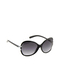

In [35]:
# Testing ou algorithm ouput with a static input and static output
Image('16871.jpg')

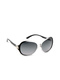

In [22]:
Image(filenames[indices[0][1]])

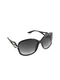

In [23]:
Image(filenames[indices[0][2]])

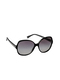

In [24]:
Image(filenames[indices[0][3]])

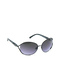

In [25]:
Image(filenames[indices[0][4]])

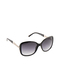

In [26]:
Image(filenames[indices[0][5]])

In [27]:
import random

def retrieval_accuracy(filenames, model, n_samples=10, n_neighbors=6):
    correct = 0
    for _ in range(n_samples):
        # Randomly select an image
        query_index = random.randint(0, len(filenames) - 1)
        query_image = filenames[query_index]

        
        query_features = extract_features_from_images(query_image, model)

        
        distances, indices = neighbors.kneighbors([query_features])

        
        if query_index in indices[0]:
            correct += 1

    accuracy = correct / n_samples
    return accuracy


accuracy = retrieval_accuracy(filenames, model)
print(f"Retrieval Accuracy: {accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Retrieval Accuracy: 100.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


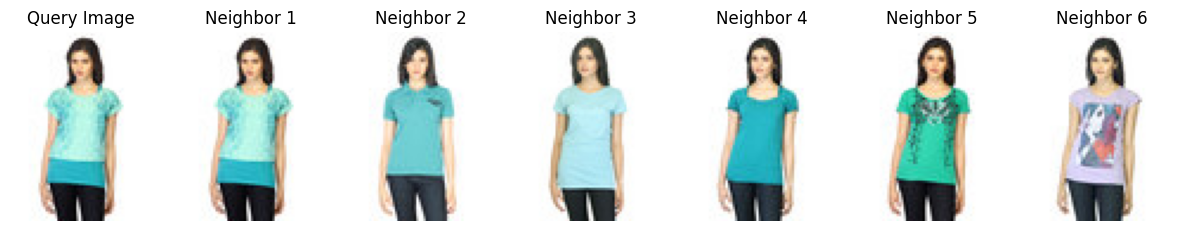

In [28]:
def visualize_retrieval(filenames, model, neighbors, n_neighbors=6):
    query_index = random.randint(0, len(filenames) - 1)
    query_image = filenames[query_index]
    query_features = extract_features_from_images(query_image, model)
    distances, indices = neighbors.kneighbors([query_features])

    plt.figure(figsize=(15, 5))

    # query image
    plt.subplot(1, n_neighbors + 1, 1)
    plt.imshow(image.load_img(query_image))
    plt.title("Query Image")
    plt.axis('off')

    # Show nearest neighbors
    for i, idx in enumerate(indices[0]):
        plt.subplot(1, n_neighbors + 1, i + 2)
        plt.imshow(image.load_img(filenames[idx]))
        plt.title(f"Neighbor {i + 1}")
        plt.axis('off')

    plt.show()

# VisualizIing a random retrieval from the dataset
visualize_retrieval(filenames, model, neighbors)


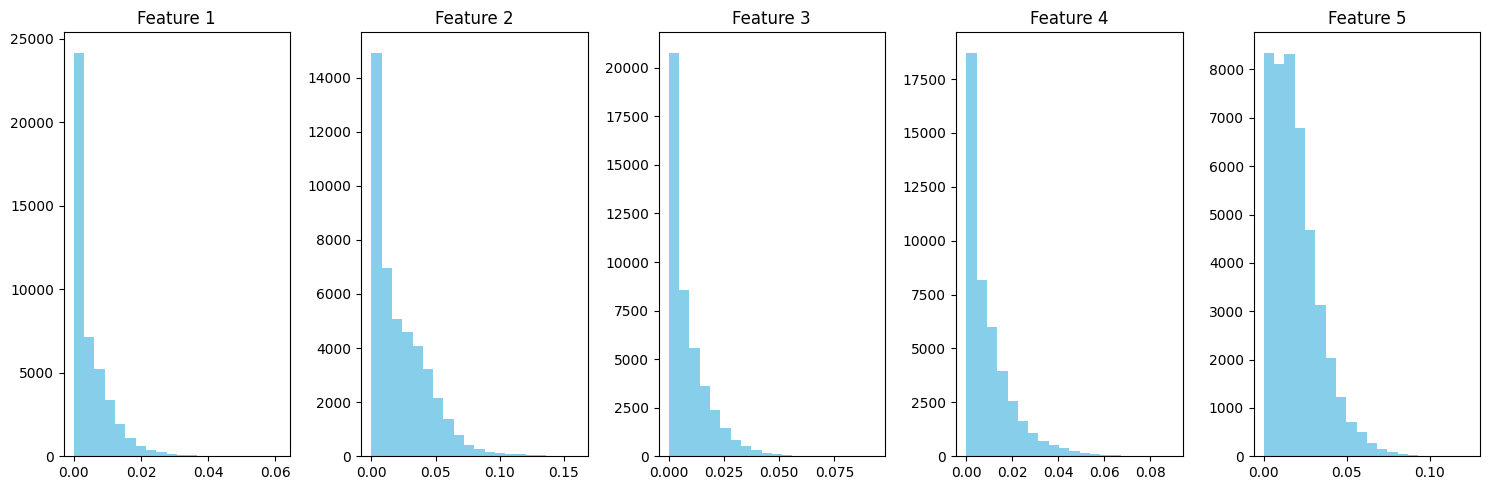

In [29]:
import matplotlib.pyplot as plt

# Load the precomputed features
Image_features = pkl.load(open('Images_features.pkl','rb'))

# Convert to a NumPy array for easier manipulation
image_features_array = np.array(Image_features)

# Plotting histograms of the first few features
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.hist(image_features_array[:, i], bins=20, color='skyblue')
    plt.title(f'Feature {i+1}')
plt.tight_layout()
plt.show()


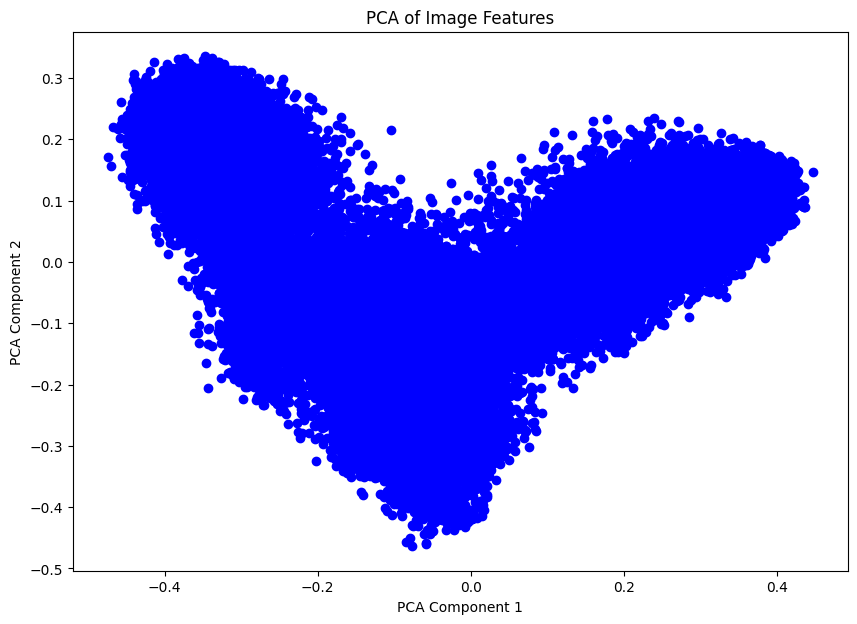

In [34]:

image_features = pkl.load(open('Images_features.pkl', 'rb'))

# Reducing the dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(image_features)

# PLotting our 2D representation of the feature vectors
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', marker='o')

plt.title('PCA of Image Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# # If you want to annotate the points with filenames we can use this code in extra but as we have large set then this would make it clumpsy
# for i in range(len(filenames)):
#     plt.annotate(os.path.basename(filenames[i]), (pca_result[i, 0], pca_result[i, 1]))

plt.show()

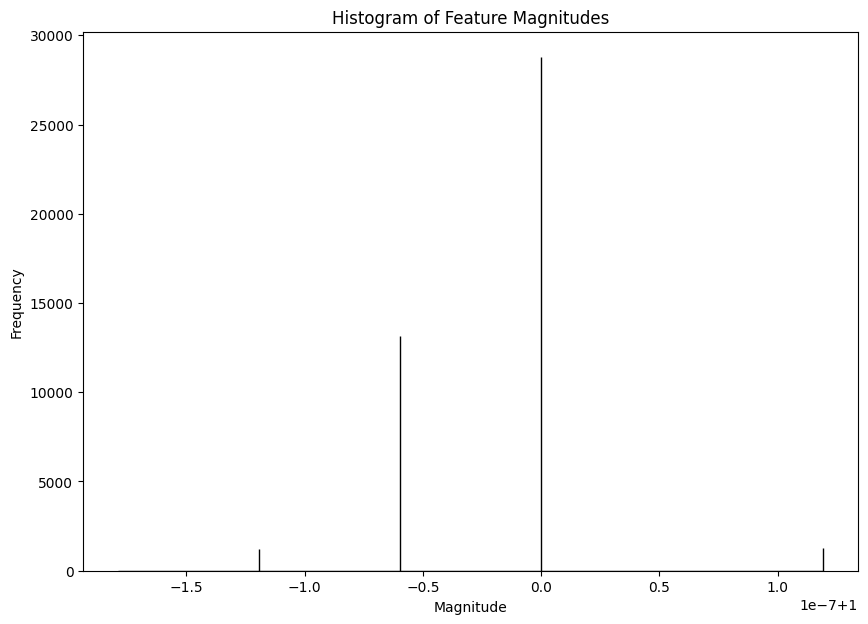

In [40]:
import numpy as np

# Compute the magnitude of each feature vector
magnitude = np.linalg.norm(image_features, axis=1)

# Plot histogram
plt.figure(figsize=(10, 7))
plt.hist(magnitude, bins=30, color='blue', edgecolor='black')

plt.title('Histogram of Feature Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()


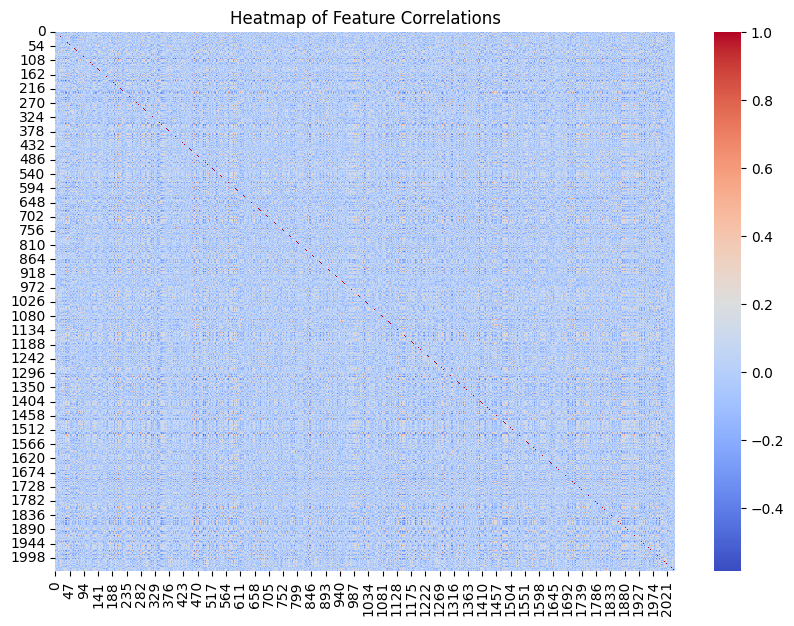

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


image_features = np.array(image_features)

# correlation matrix
correlation_matrix = np.corrcoef(image_features, rowvar=False)


plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Heatmap of Feature Correlations')
plt.show()
